In [1]:
import os
import pickle
import scipy.io as io

import sys

sys.path.append('..')

from tepfit.fit import ParamsJR, Model_fitting, RNNJANSEN, Costs, OutputNM

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import time
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter

sns.set()

In [2]:
eeg = io.loadmat('../data/TEP_BA19.mat')['Y']
mean = np.mean(eeg, 2)
mean

array([[-0.60191419, -0.60447054, -0.60693998, ...,  0.3024894 ,
         0.30081502,  0.30077748],
       [-0.48782249, -0.47761021, -0.46741699, ...,  0.2628697 ,
         0.26331898,  0.26556966],
       [-0.35198514, -0.34106787, -0.32918033, ...,  0.14102615,
         0.15169064,  0.16406653],
       ...,
       [ 0.31280001,  0.29492317,  0.27548991, ..., -0.40062669,
        -0.40673823, -0.41643048],
       [ 0.2479285 ,  0.23426442,  0.21855863, ..., -0.33632902,
        -0.35285902, -0.37621509],
       [ 0.04642896,  0.01720681, -0.01298985, ..., -0.23703849,
        -0.25016201, -0.2709811 ]])

In [3]:
mean.T.shape

(1741, 60)

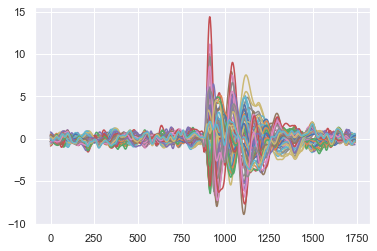

In [4]:
for i in range(1):
    plt.plot(mean.T)
plt.show()

In [5]:
# declare all the variables in one place
sc_file = '../data/Schaefer2018_200Parcels_7Networks_count.csv'         # 200x200 matrix
high_file = '../data/only_high_trial.mat'                               # 20x62x2000 matrix
dist_file = '../data/Schaefer2018_200Parcels_7Networks_distance.csv'    # 200x200 matrix
file_labels = '../data/label_ts_corrected'                              # 200x2000 matrix
file_leadfield = '../data/leadfield'                                    # 62x200 matrix
file_eeg = '../data/real_EEG'                                           # 62x2000 matrix
stim_weights_file = '../data/stim_weights.npy'                          # 200 vector

# open leadfield matrix file
lm = np.load(file_leadfield, allow_pickle=True)

# gm is the same shape as lm, gm = grand mean structural connectome from 400 HCP age=[21, 35]
gm = lm

# show the shape
print(gm.shape)

(62, 200)


In [7]:
# data = io.loadmat(high_file)['only_high_trial']

# for idx in range(data.shape[0]):
#     plt.plot(data[idx].T)
#     plt.show()

In [6]:
# open files
eeg = np.load(file_eeg, allow_pickle=True)
# data_high = io.loadmat(high_file)
data_high = mean
stim_weights = np.load(stim_weights_file)

sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
sc = 0.5 * (sc + sc.T)
sc =np.log1p(sc) / np.linalg.norm(np.log1p(sc))

dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values

ki0 = stim_weights[:, np.newaxis]

print('ki0 shape:', ki0.shape)
print(f'Leadfield min: {lm.min()}, max: {lm.max()}')
print('High trial shape:', data_high.shape)

ki0 shape: (200, 1)
Leadfield min: -125.8151626586914, max: 268.3122253417969
High trial shape: (60, 1741)


In [14]:
stim_weights

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00823931,
       0.        , 0.        , 0.76388556, 0.39933604, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13352703, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01540833,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [9]:
# # visualize high trial 
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].plot(data_high['only_high_trial'][0].T)
# ax[1].plot(data_high['only_high_trial'][6].T)
# plt.show()

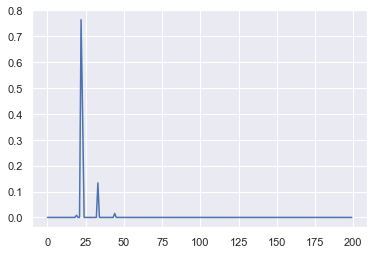

In [10]:
plt.plot(ki0)
plt.show()

In [7]:
# files = ['../data/TEP_BA4.mat', '../data/TEP_BA6.mat', '../data/TEP_BA7.mat', '../data/TEP_BA19.mat']
# data_high = np.zeros((4, 62, 2000))

# for idx in range(4):
#     data_high[idx] = np.pad(np.mean(io.loadmat(files[idx])['Y'], 2), ((0, 2), (0, 259)), 'minimum')

# data_high.shape

In [12]:
data_high.shape


(60, 1741)

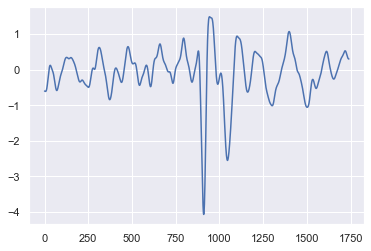

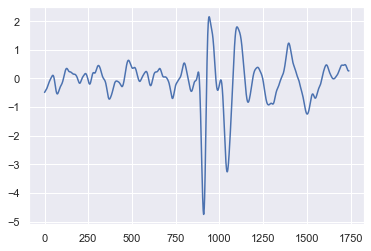

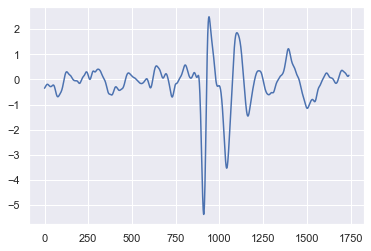

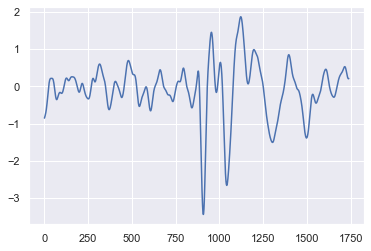

In [8]:
for idx in range(4):
    plt.plot(data_high[idx].T)
    plt.show()

In [20]:
output_size

62

In [21]:
# start timing to see how long the model trains
start_time = time.time()

# the number of ROIs
node_size = stim_weights.shape[0]

# output should be a TS with 200 values to match empirical data (this would be used as Y-axis for some reason)
output_size = 60

# model specs
batch_size = 50            # the number of EEG signals to simulate
step_size = 0.001         # how much to change on each iteration
input_size = 3             # the number of states with noise as input
num_epoches = 5          # how long to train the model for
state_size = 6             # the number of states in the JansenRit model
base_batch_num = 20

# integration step
tr = 0.001

# the output will match 62x200 dims
lm_v = np.zeros((output_size, node_size))

# create output path
output = '../leadfield_from_mne'

if not os.path.exists(output):
    os.mkdir(output)


########################################################
###                   START TRAINING                 ###
########################################################

# uncomment and change N if you want several subjects + use indentation
# N = 20
# for i in range(N):
i = 0   # if you uncomment, comment this one
data_mean = np.array([data_high] * num_epoches)

# create parameters for Jansen-Rit model 
par = ParamsJR('JR', A=[3.25, 0], a=[100, 0.5], B=[22, 0], b=[50, 1], g=[1000, 0.1],
               c1=[135, 0.2], c2=[135*0.8, 0.4], c3=[135*0.25, 0.8], c4=[135*0.25, 0.8],
               std_in=[100, 10], vmax= [5, 0], v0=[6,0], r=[0.56, 0], y0=[2 * np.ones((output_size, 1)), 2 * np.ones((output_size, 1))], mu=[1., 2.5], k=[10, .3], cy0 = [5, 0], ki=[ki0, 0],
               lm=[lm, 1.0 * np.ones((output_size, node_size)) + lm_v],
               w_bb=[sc, 50 * np.ones((node_size, node_size))])

# create a Jansen-Rit model
model = RNNJANSEN(input_size, node_size, batch_size, step_size, output_size, tr, sc, lm, dist, 
                  fit_gains_flat=True, fit_lfm_flat=False, param=par)

# fit the model for 120 epochs, 
F = Model_fitting(model, data_mean[:,:,-400:], num_epoches, cost=0)

# fit train data
u = np.zeros((node_size, 10, 400))   # 200x10x400 matrix
u[:, :, 110:120] = 1000
output_train = F.train(u=u)

u = np.zeros((node_size,10,400))
u[:,:,110:120]= 1000
X0 = np.random.uniform(0, 5, (node_size, state_size))
hE0 = np.random.uniform(0, 5, (node_size, 500))

output_test = F.test(X0, hE0, base_batch_num, u=u)

sc_mod = np.zeros((200,200))
mask = np.tril_indices(200,-1)

sc_mod[mask] = F.output_sim.weights[-10:,:].mean(0)
sc_mod = sc_mod+sc_mod.T
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.imshow(np.log1p(sc_mod), cmap = 'bwr')
plt.show()

end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

ValueError: operands could not be broadcast together with shapes (62,200) (60,200) 

In [ ]:
# save output
filename = '../data/TEP_BA4' + str(i) + '_0.0001step.pkl'
with open(filename, 'wb') as f:
    pickle.dump(F, f)

outfilename = '../data/TEP_BA4' + str(i) + '_0.0001step.pkl'

with open(outfilename, 'wb') as f:
    pickle.dump(F.output_sim, f)

plt.plot((F.output_sim.E_test-F.output_sim.I_test).T)
plt.title('Test: sourced EEG')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax[0].plot(F.output_sim.eeg_test.T)
ax[0].set_title('Test')
ax[1].plot(data_high[i].T[900:1300,:])
ax[1].set_title('empirical')
plt.show()

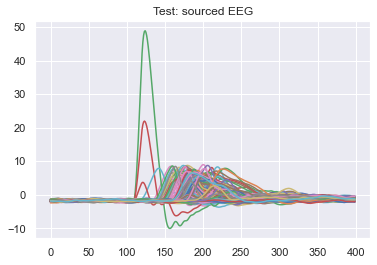

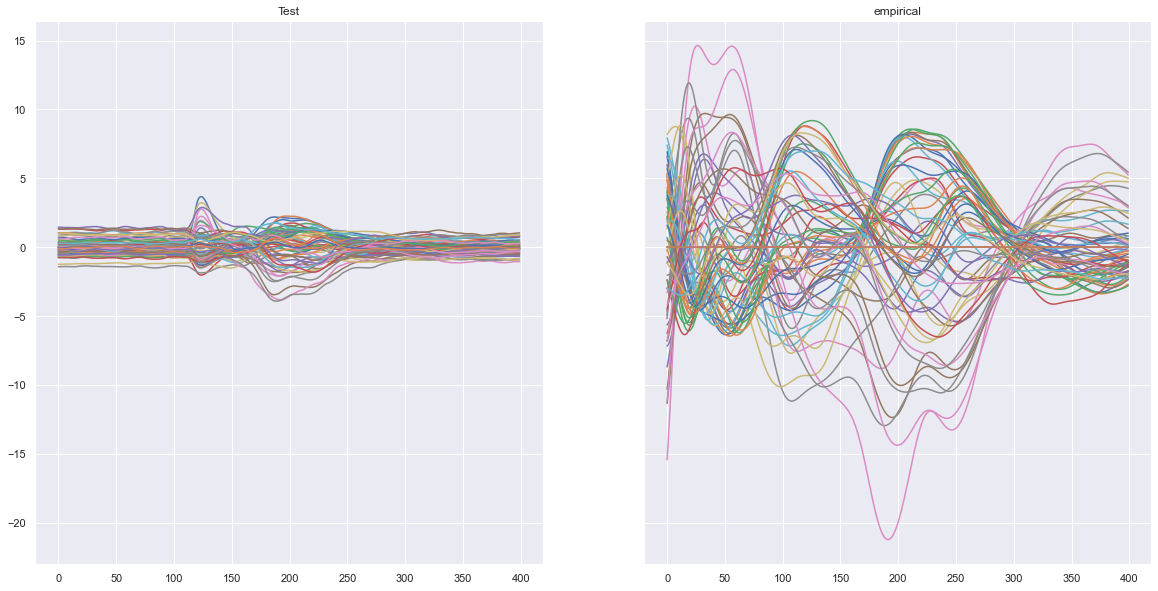

In [20]:
# save output
filename = '../data/TEP_BA4' + str(i) + '_0.0001step.pkl'
with open(filename, 'wb') as f:
    pickle.dump(F, f)

outfilename = '../data/TEP_BA4' + str(i) + '_0.0001step.pkl'

with open(outfilename, 'wb') as f:
    pickle.dump(F.output_sim, f)

plt.plot((F.output_sim.E_test-F.output_sim.I_test).T)
plt.title('Test: sourced EEG')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax[0].plot(F.output_sim.eeg_test.T)
ax[0].set_title('Test')
ax[1].plot(data_high[i].T[900:1300,:])
ax[1].set_title('empirical')
plt.show()

In [57]:
dir(F)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cost',
 'model',
 'num_epoches',
 'output_sim',
 'save',
 'test',
 'train',
 'ts',
 'u']

In [59]:
print(

'A - ', F.model.A,

'\na - ', F.model.a,

'\nB - ', F.model.B,

'\nb - ', F.model.b,

'\nc1 - ', F.model.c1,

'\nc2 - ', F.model.c2,

'\nc3 - ', F.model.c3,

'\nc4 - ', F.model.c4,

'\nr - ', F.model.r,

'\nv0 - ', F.model.v0,

'\ng - ', F.model.g,

'\nk - ', F.model.k,

'\nmu - ', F.model.mu,

'\nstd_in - ', F.model.std_in,

'\nstep_size - ', F.model.step_size,

'\nState variables - ', F.model.state_names,

)

A -  tensor(3.2500) 
a -  Parameter containing:
tensor(97.8838, requires_grad=True) 
B -  tensor(22.) 
b -  Parameter containing:
tensor(50.3361, requires_grad=True) 
c1 -  Parameter containing:
tensor(137.5374, requires_grad=True) 
c2 -  Parameter containing:
tensor(109.1695, requires_grad=True) 
c3 -  Parameter containing:
tensor(31.2616, requires_grad=True) 
c4 -  Parameter containing:
tensor(32.0400, requires_grad=True) 
r -  tensor(0.5600) 
v0 -  tensor(6.) 
g -  Parameter containing:
tensor(994.4836, requires_grad=True) 
k -  Parameter containing:
tensor(9.2833, requires_grad=True) 
mu -  Parameter containing:
tensor(0.9316, requires_grad=True) 
std_in -  Parameter containing:
tensor(66.7893, requires_grad=True) 
step_size -  tensor(1.0000e-04) 
State variables -  ['E', 'Ev', 'I', 'Iv', 'P', 'Pv']


### Step size=0.001

In [8]:
files = ['../data/TEP_BA4.mat', '../data/TEP_BA6.mat', '../data/TEP_BA7.mat', '../data/TEP_BA19.mat']
data_high = np.zeros((4, 62, 2000))

for idx in range(4):
    data_high[idx] = np.pad(np.mean(io.loadmat(files[idx])['Y'], 2), ((0, 2), (0, 259)), 'minimum')

data_high.shape

(4, 62, 2000)

In [23]:
# start timing to see how long the model trains
start_time = time.time()

# the number of ROIs
node_size = stim_weights.shape[0]

# output should be a TS with 200 values to match empirical data (this would be used as Y-axis for some reason)
output_size = 60

# model specs
batch_size = 50            # the number of EEG signals to simulate
step_size = 0.001         # how much to change on each iteration
input_size = 3             # the number of states with noise as input
num_epoches = 1          # how long to train the model for
state_size = 6             # the number of states in the JansenRit model
base_batch_num = 20

# integration step
tr = 0.001

# the output will match 62x200 dims
lm_v = np.zeros((output_size, node_size))

# create output path
output = '../leadfield_from_mne'

if not os.path.exists(output):
    os.mkdir(output)


########################################################
###                   START TRAINING                 ###
########################################################

# uncomment and change N if you want several subjects + use indentation
# N = 20
# for i in range(N):
i = 0   # if you uncomment, comment this one
data_mean = np.array([data_high[i]] * num_epoches)
print(data_mean.shape)

# create parameters for Jansen-Rit model 
par = ParamsJR('JR', A=[3.25, 0], a=[100, 0.5], B=[22, 0], b=[50, 1], g=[1000, 0.1],
               c1=[135, 0.2], c2=[135*0.8, 0.4], c3=[135*0.25, 0.8], c4=[135*0.25, 0.8],
               std_in=[100, 10], vmax= [5, 0], v0=[6,0], r=[0.56, 0], 
               y0=[2 * np.ones((output_size, 1)), 2 * np.ones((output_size, 1))], mu=[1., 2.5], 
               k=[10, .3], cy0 = [5, 0], ki=[ki0, 0],
               lm=[lm, 1.0 * np.ones((output_size, node_size)) + lm_v],
               w_bb=[sc, 50 * np.ones((node_size, node_size))])

# create a Jansen-Rit model
model = RNNJANSEN(input_size, node_size, batch_size, step_size, output_size, tr, sc, lm, dist, 
                  fit_gains_flat=True, fit_lfm_flat=False, param=par)

# fit the model for 120 epochs, 
F = Model_fitting(model, data_mean[:,:,900:1300], num_epoches, cost=0)

# fit train data
u = np.zeros((node_size, 10, 400))   # 200x10x400 matrix
u[:, :, 110:120] = 1000
output_train = F.train(u=u)

u = np.zeros((node_size, 10, 400))
u[:,:,110:120]= 1000
X0 = np.random.uniform(0, 5, (node_size, state_size))
hE0 = np.random.uniform(0, 5, (node_size, 500))

print(X0.shape, hE0.shape, base_batch_num, u.shape)

output_test = F.test(X0, hE0, base_batch_num, u=u)

sc_mod = np.zeros((200,200))
mask = np.tril_indices(200,-1)

sc_mod[mask] = F.output_sim.weights[-10:,:].mean(0)
sc_mod = sc_mod+sc_mod.T
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.imshow(np.log1p(sc_mod), cmap = 'bwr')
plt.show()

end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

(1, 1741)


ValueError: operands could not be broadcast together with shapes (62,200) (60,200) 

(120, 62, 2000)
epoch: 0 loss: 14516.642
		Correlation coefficient: -0.02799871100803165 		cos_sim: -0.026342806607920075

epoch: 10 loss: -13399.213
		Correlation coefficient: -0.011171043283794391 		cos_sim: 0.017541586467948154

epoch: 20 loss: -18944.904
		Correlation coefficient: 0.0006962008722379179 		cos_sim: 0.044123405405032914

epoch: 30 loss: -22311.455
		Correlation coefficient: 0.019765873043869068 		cos_sim: 0.07017481144678168

epoch: 40 loss: -24777.01
		Correlation coefficient: 0.04507811100505019 		cos_sim: 0.10263599238844048

epoch: 50 loss: -26735.559
		Correlation coefficient: 0.06804622827300216 		cos_sim: 0.13323871980324828

epoch: 60 loss: -28367.04
		Correlation coefficient: 0.10153859144908702 		cos_sim: 0.18297159886073486

epoch: 70 loss: -29769.613
		Correlation coefficient: 0.12969725514473499 		cos_sim: 0.23005607292021818

epoch: 80 loss: -31002.754
		Correlation coefficient: 0.16616916216287686 		cos_sim: 0.26936430287339314

epoch: 90 loss: -32105.2

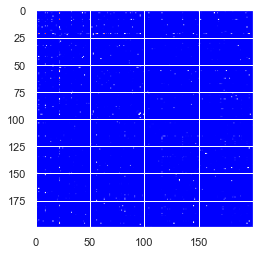

running time is  2131.8528587818146 's


In [13]:
# start timing to see how long the model trains
start_time = time.time()

# the number of ROIs
node_size = stim_weights.shape[0]

# output should be a TS with 200 values to match empirical data (this would be used as Y-axis for some reason)
output_size = gm.shape[0]

# model specs
batch_size = 50            # the number of EEG signals to simulate
step_size = 0.0001         # how much to change on each iteration
input_size = 3             # the number of states with noise as input
num_epoches = 120          # how long to train the model for
state_size = 6             # the number of states in the JansenRit model
base_batch_num = 20

# integration step
tr = 0.001

# the output will match 62x200 dims
lm_v = np.zeros((output_size, node_size))

# create output path
output = '../leadfield_from_mne'

if not os.path.exists(output):
    os.mkdir(output)


########################################################
###                   START TRAINING                 ###
########################################################

# uncomment and change N if you want several subjects + use indentation
# N = 20
# for i in range(N):
i = 0   # if you uncomment, comment this one
data_mean = np.array([data_high[i]] * num_epoches)
print(data_mean.shape)

# create parameters for Jansen-Rit model 
par = ParamsJR('JR', A=[3.25, 0], a=[100, 0.5], B=[22, 0], b=[50, 1], g=[1000, 0.1],
               c1=[135, 0.2], c2=[135*0.8, 0.4], c3=[135*0.25, 0.8], c4=[135*0.25, 0.8],
               std_in=[100, 10], vmax= [5, 0], v0=[6,0], r=[0.56, 0], y0=[2 * np.ones((output_size, 1)), 2 * np.ones((output_size, 1))], mu=[1., 2.5], k=[10, .3], cy0 = [5, 0], ki=[ki0, 0],
               lm=[lm, 1.0 * np.ones((output_size, node_size)) + lm_v],
               w_bb=[sc, 50 * np.ones((node_size, node_size))])

# create a Jansen-Rit model
model = RNNJANSEN(input_size, node_size, batch_size, step_size, output_size, tr, sc, lm, dist, 
                  fit_gains_flat=True, fit_lfm_flat=False, param=par)

# fit the model for 120 epochs, 
F = Model_fitting(model, data_mean[:,:,900:1300], num_epoches, cost=0)

# fit train data
u = np.zeros((node_size, 10, 400))   # 200x10x400 matrix
u[:, :, 110:120] = 1000
output_train = F.train(u=u)

u = np.zeros((node_size,10,400))
u[:,:,110:120]= 1000
X0 = np.random.uniform(0, 5, (node_size, state_size))
hE0 = np.random.uniform(0, 5, (node_size, 500))

output_test = F.test(X0, hE0, base_batch_num, u=u)

sc_mod = np.zeros((200,200))
mask = np.tril_indices(200,-1)


sc_mod[mask] = F.output_sim.weights[-10:,:].mean(0)
sc_mod = sc_mod+sc_mod.T
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.imshow(np.log1p(sc_mod), cmap = 'bwr')
plt.show()

end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

### Step size=0.0001 and num_epoch=300

In [64]:
# start timing to see how long the model trains
start_time = time.time()

# the number of ROIs
node_size = stim_weights.shape[0]

# output should be a TS with 200 values to match empirical data (this would be used as Y-axis for some reason)
output_size = gm.shape[0]

# model specs
batch_size = 50            # the number of EEG signals to simulate
step_size = 0.0001         # how much to change on each iteration
input_size = 3             # the number of states with noise as input
num_epoches = 300          # how long to train the model for
state_size = 6             # the number of states in the JansenRit model
base_batch_num = 20

# integration step
tr = 0.001

# the output will match 62x200 dims
lm_v = np.zeros((output_size, node_size))

# create output path
output = '../leadfield_from_mne'

if not os.path.exists(output):
    os.mkdir(output)


########################################################
###                   START TRAINING                 ###
########################################################

# uncomment and change N if you want several subjects + use indentation
# N = 20
# for i in range(N):
i = 0   # if you uncomment, comment this one
data_mean = np.array([data_high[i]] * num_epoches)
print(data_mean.shape)

# create parameters for Jansen-Rit model 
par = ParamsJR('JR', A=[3.25, 0], a=[100, 0.5], B=[22, 0], b=[50, 1], g=[1000, 0.1],
               c1=[135, 0.2], c2=[135*0.8, 0.4], c3=[135*0.25, 0.8], c4=[135*0.25, 0.8],
               std_in=[100, 10], vmax= [5, 0], v0=[6,0], r=[0.56, 0], y0=[2 * np.ones((output_size, 1)), 2 * np.ones((output_size, 1))], mu=[1., 2.5], k=[10, .3], cy0 = [5, 0], ki=[ki0, 0],
               lm=[lm, 1.0 * np.ones((output_size, node_size)) + lm_v],
               w_bb=[sc, 50 * np.ones((node_size, node_size))])

# create a Jansen-Rit model
model = RNNJANSEN(input_size, node_size, batch_size, step_size, output_size, tr, sc, lm, dist, 
                  fit_gains_flat=True, fit_lfm_flat=False, param=par)

# fit the model for 120 epochs, 
F = Model_fitting(model, data_mean[:,:,900:1300], num_epoches, cost=0)

# fit train data
u = np.zeros((node_size, 10, 400))   # 200x10x400 matrix
u[:, :, 110:120] = 1000
output_train = F.train(u=u)

u = np.zeros((node_size,10,400))
u[:,:,110:120]= 1000
X0 = np.random.uniform(0, 5, (node_size, state_size))
hE0 = np.random.uniform(0, 5, (node_size, 500))

output_test = F.test(X0, hE0, base_batch_num, u=u)

sc_mod = np.zeros((200,200))
mask = np.tril_indices(200,-1)

sc_mod[mask] = F.output_sim.weights[-10:,:].mean(0)
sc_mod = sc_mod+sc_mod.T
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.imshow(np.log1p(sc_mod), cmap = 'bwr')
plt.show()

end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

(300, 62, 2000)
epoch: 0 loss: 317.98447
		Correlation coefficient: -0.02319245458421322 		cos_sim: -0.017737072357666087



KeyboardInterrupt: 